# Fine tunning for image classification

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics             
from sklearn.metrics import roc_curve
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader, Dataset
from torch.utils.data import random_split
from torchvision import datasets, models
import torchvision.transforms as transforms
from PIL import Image           #PIL is python image library
import os
import glob
import copy
import random
from torchmetrics.classification import BinaryAccuracy, BinaryAUROC
import wandb
from sklearn.metrics import  roc_curve
%matplotlib inline

# Image preprocessing

In [11]:
# chroot_dire some patients from the whole dataset for hyperparameter tunnning
root_dir = sorted(glob.glob('your directory/stitched'))

In [10]:
#get annotaion file
annotation_df = pd.read_csv('annotation.csv')
annotation_df = annotation_df[['ID', 'binary grade']]

In [2]:
# build transformer to transform images to tensors
transformer =  transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),                # mean and std are 0.5
    transforms.Resize((224,224), antialias=True)                              # resize the images
])

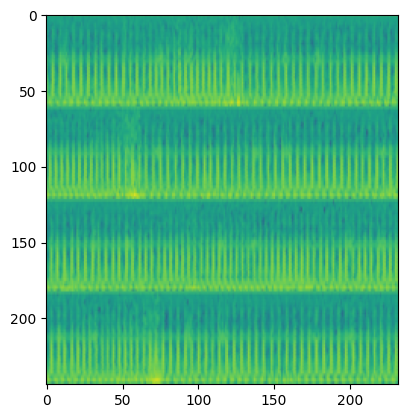

In [ ]:
# Visualize one stitched spectrogram image using tightlayout 
orig_img = Image.open('yourpath/image.png')
plt.imshow(orig_img)

In [ ]:
# define random seeds
random_seed = 42          
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)

In [12]:
# make a dataset reader based on my folder arrangment
class my_image_dataset(Dataset):
    def __init__(self, root_dir, transformer, annotation_file):
        self.root_dir = root_dir
        self.annotation = annotation_file
        self.transformer = transformer
        self.samples = []
        
        #define each image path and its label(class 0 or 1)
        for img_path in self.root_dir:
            class_label = (self.annotation['ID']['binary grade']).iloc[0]     #get annotation
            image_path = glob.glob(os.path.join(img_path,'*.png')) 
            self.samples.extend([[i, class_label] for i in image_path])   # add all items of the loop to one list and add labels for each image
    
    # getting number of data later using len(dataset) function
    def __len__(self):
            return len(self.samples)

    # read images and their labels and apply transformer on them    
    def __getitem__(self, idx):
        image_path, class_label = self.samples[idx]
        image = Image.open(image_path)              #read the image
        image = self.transformer(image)            # apply transformer on the image
        return image, class_label

# Define the models

In [13]:
# Swintransformer model
class MySwint(nn.Module):
    def __init__(self):
        super().__init__()
        
        pretrained_swin_T_weights = models.Swin_T_Weights.DEFAULT
        my_model = models.swin_t(weights=pretrained_swin_T_weights)  #load model
        num_features = my_model.head.in_features
        my_model.head = nn.Linear(in_features=num_features, out_features=2)
        
        self.model = my_model

    def forward(self, x):
        return self.model(x)

In [4]:
# Mobilenet model
class MyMobileNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        
        # Load MobileNetV2 model
        backbone = models.mobilenet_v2(pretrained=True)
        
        # Freeze feature extraction layers
        for param in backbone.features.parameters():
            param.requires_grad_(False)
        
        # Modify classifier for binary classification
        num_features = backbone.classifier[1].in_features
        backbone.classifier[1] = nn.Linear(num_features, num_classes)
        
        # Initialize new linear layer weights
        nn.init.xavier_uniform_(backbone.classifier[1].weight)
        nn.init.constant_(backbone.classifier[1].bias, 0.0)
        
        self.backbone = backbone

    def forward(self, x):
        return self.backbone(x)

In [5]:
# Resnet18 model
class MyResnet18(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Load ResNet18 model
        self.model = models.resnet18(pretrained=True)   #load resnet18 model
        num_features = self.model.fc.in_features     #extract fc layers features
        
        # Replace the fully connected layers
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2),            #(num_of_class == 2)
        )

    def forward(self, x):
        return self.model(x)

In [14]:
my_model_swint = MySwint()
my_model_mobilenet = MyMobileNet()
my_model_resnet18 = MyResnet18()

# Move data and model to GPU

In [14]:
#function for moving data and model to a chosen device(gpu or cpu)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def to_device(data, device):    
    if isinstance(data, (list, tuple, tuple)):
        return [to_device(x, device) for x in data]    
    return data.to(device, non_blocking=True)

In [15]:
#create a class to wrap our existing data loaders and move batches of data to the selected device.
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    'Yield a batch of data after moving it to device'    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)     #number of batches           

In [16]:
# Choose the model you want to train
model_gpu = to_device(my_model_swint,device)

In [ ]:
# choose train and test data
train_set_path_full = [path for path in root_dir if 'train' in path]
test_set_path = [path for path in root_dir if 'test' in path]

In [19]:
# Create your custom dataset
train_ds_full = my_image_dataset(root_dir=train_set_path, transformer=transformer, annotation_file=annotation_df)
test_ds = my_image_dataset(root_dir=test_set_path, transformer=transformer_test, annotation_file=annotation_df)

# split train and validation set(for internal cross validation)
validation_size = int(0.2* len(train_ds_full))
train_size = len(train_ds_full) - validation_size
train_ds, val_ds = random_split(train_ds_full, [train_size, validation_size])

# seperating data into batches
batch_size = 254
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
validation_dl = DataLoader(val_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size)

# move data to GPU
train_loader = DeviceDataLoader(train_dl,device)
validation_loader = DeviceDataLoader(validation_dl,device)
test_loader = DeviceDataLoader(test_dl,device)

print('train size:', len(train_ds), 'validation size:', len(val_ds), 'test size:', len(test_ds) )

train size: 25133 validation size: 6283 test size: 38398


# Train and validation phase

In [21]:
# hyperparameters
opt_func = torch.optim.Adam
epochs = 120
lr = 1e-3

In [22]:
# Training the model
start = time.time()           #count the Execution time
#save the initial model to start from the begining for each fold
model = model_gpu
optimizer = opt_func(model.parameters(), lr = lr) 

best_auc = 0
best_model = None

for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    batch_out = []
    batch_labels = []
    
    # Training Phase 
    model.train()
    for batch in train_loader:
        images, labels = batch
        labels = F.one_hot(labels, 2).float()       # transform labels to one hot format
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        out = model(images)
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Calculate the average loss for the epoch
    epoch_loss_train = train_loss / len(train_loader)

    # Validation phase
    model.eval()    
    with torch.no_grad():
        for batch in validation_loader:
            images, labels = batch
            labels = F.one_hot(labels, 2).float()       # transform labels to one hot format
            images, labels = images.to(device), labels.to(device)
            batch_labels.append(labels)              # append labels of all batches
            out_V = model(images)
            batch_out.append(out_V)                       # append output of all batches
            criterion = nn.BCEWithLogitsLoss()
            loss_V = criterion(out_V, labels)

            # sum of all losses
            val_loss += loss_V.item()

    # calculate average loss for each epoch
    epoch_loss_val = val_loss / len(validation_loader)

    # concatenate output and labels of each epoch
    epoch_labels = torch.cat(batch_labels)[:,1]
    epoch_out = torch.cat(batch_out)    # output is the prediction probability since we use sigmoid in the last layer of Fc

    # calculate evaluation metrics
    # prediction probability and labels
    probabilities = torch.softmax(epoch_out, dim=1)[:,1]
    # Accuracy
    acc_metrics = BinaryAccuracy().to(device)
    acc = acc_metrics(probabilities, epoch_labels)
    # AUC
    auc_metrics = BinaryAUROC()
    auc = auc_metrics(probabilities, epoch_labels)
    
    # save the best model based on validation AUC
    if auc >= best_auc:
        best_auc = auc
        best_model = copy.deepcopy(model)
        best_epoch = epoch

    # weight and biases logs to 
    wandb.log({"epoch": epoch, "train loss": epoch_loss_train, "validation loss": epoch_loss_val, "validation acc": acc.item(), "AUC": auc.item()})

    print(epoch,'train_loss:', epoch_loss_train ,'val_loss',epoch_loss_val, 'val_acc:', acc.item() ,'val_AUC', auc.item(), 'prediction', probabilities, 'target', epoch_labels )

wandb.finish()

end = time.time()
total_time = end - start
print(f'Total Execution Time: {total_time}')

0 train_loss: 0.6804834197799061 val_loss 0.6662928781124077 val_acc: 0.606716513633728 val_AUC 0.6043397188186646 prediction tensor([0.3761, 0.3375, 0.3654,  ..., 0.2465, 0.4878, 0.3834], device='cuda:0') target tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')
1 train_loss: 0.6681512165008914 val_loss 0.6588124590690689 val_acc: 0.6048066020011902 val_AUC 0.635338306427002 prediction tensor([0.4025, 0.4237, 0.3733,  ..., 0.2109, 0.3595, 0.3650], device='cuda:0') target tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')
2 train_loss: 0.6617102454636843 val_loss 0.6525576885300454 val_acc: 0.6065573692321777 val_AUC 0.6609771251678467 prediction tensor([0.4021, 0.3057, 0.3475,  ..., 0.2181, 0.3811, 0.3682], device='cuda:0') target tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')
3 train_loss: 0.6566611467730301 val_loss 0.6468571972365331 val_acc: 0.6098996996879578 val_AUC 0.6737164258956909 prediction tensor([0.4306, 0.3698, 0.3231,  ..., 0.1330, 0.4294, 0.4277], de

AUC,▁▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
validation acc,▁▁▂▃▃▃▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇███████
validation loss,██▇▇▆▆▆▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
AUC,0.90402
epoch,119
train loss,0.42462
validation acc,0.81617
validation loss,0.38011


Total Execution Time: 50466.742733478546


# Test Phase

In [ ]:
# Test phase
test_loss = 0.0
batch_out_test = []
batch_labels_test = []
model.eval()    
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        labels = F.one_hot(labels, 2).float()       # transform labels to one hot format
        images, labels = images.to(device), labels.to(device)
        batch_labels_test.append(labels)              # append labels of all batches
        out_T = model(images)
        batch_out_test.append(out_T)                       # append output of all batches
        criterion = nn.BCEWithLogitsLoss()
        loss_T = criterion(out_T, labels)

        # sum of all losses
        test_loss += loss_T.item()

# calculate average loss for each epoch
epoch_loss_test = test_loss / len(test_loader)

# concatenate output and labels of each epoch
epoch_labels_test = torch.cat(batch_labels_test)[:, 1]
epoch_out_test = torch.cat(batch_out_test) 

# calculate evaluation metrics
# prediction probability and labels
probabilities = torch.softmax(epoch_out_test, dim=1)[:, 1]
# Accuracy
acc_metrics = BinaryAccuracy().to(device)
acc = acc_metrics(probabilities, epoch_labels_test)
# AUC
auc_metrics = BinaryAUROC()
auc = auc_metrics(probabilities, epoch_labels_test)

print('test_loss:', epoch_loss_test , 'val_acc:', acc.item() ,'val_AUC', auc.item(), 'prediction', probabilities, 'target', epoch_labels_test )

test_loss: 1.125778436382922 val_acc: 0.6094588041305542 val_AUC 0.6956005096435547 prediction tensor([0.9962, 0.9977, 0.9897,  ..., 0.9946, 0.9468, 0.9815], device='cuda:0') target tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')


auc value: 0.6956005336375187


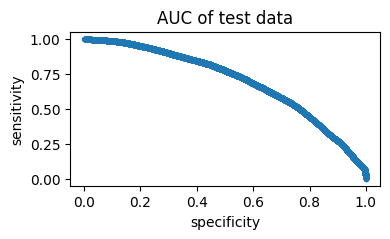

In [ ]:
# Plot test AUC
fpr, tpr, thresholds  = roc_curve(epoch_labels_test.cpu(), np.ravel(probabilities.cpu()))    #compare annotaion file labels with classifier prediction result 
sensitivity = tpr
specificity = 1-fpr

plt.figure(figsize=(4,2))
plt.plot(specificity, sensitivity, marker='.')
plt.title(f'AUC of test data')
plt.xlabel('specificity')
plt.ylabel('sensitivity')
auc_value = metrics.auc(fpr, tpr)
print('auc value:', auc_value)
plt.savefig(f'model_roc.png')
plt.show()